In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from time import time

In [2]:
# Utilities

tf_float_type = tf.float64
np_float_type = np.float64

as_tf_float = lambda x: tf.cast(x, tf_float_type)

def tf_reduce_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

In [3]:
# config toy dataset
N = 1000
D = 5
B = 100
V_true = np.random.randn(N*D).reshape([N,D])/D**0.5
V = tf.Variable(V_true, dtype=tf.float64)

In [4]:
# generator of  toy dataset
def generate(n, V):
    N,D = V.shape
    p = np.exp(V@V.T).reshape([-1])
    p /= p.sum()
    x = np.random.choice(N**2,n,p=p,replace=False)
    x = np.array([x//N, x%N]).T
    return x

In [5]:
# toy dataset
x = generate(B, V_true)

In [6]:
# mean (joint) log likelihood.
log_prob = (V_true[x[:,0]] * V_true[x[:,0]]).sum(axis=1) - np.log(N*N)
np.mean(np.exp(log_prob))

3.6618896415668785e-06

In [7]:
class simpleWord2Vec:
    
    def __init__(self, N, D, neg_prob=None):
        self.N = N
        self.D = D
        self.neg_prob = neg_prob
        self.V = tf.Variable(0.3*np.random.randn(N*D).reshape([N,D]))
        
        
    def set_vec(self, V):
        assert(type(V) == np.ndarray)
        assert((self.N, self.D) == V.shape)
        self.V = tf.Variable(V)
    
    def neg_sample_x(self, B, n_MC):
        if self.neg_prob is None:
            x_neg = np.random.choice(self.N, size=B*n_MC)
        else:
            x_neg = np.random.choice(self.N, size=B*n_MC, p=self.neg_prob)
        x_neg = x_neg.reshape([n_MC, B])
        return x_neg
    
    def _losses(self, x, x_neg):
        V1 = tf.gather(self.V, x[:,0])
        V2 = tf.gather(self.V, x[:,1])
        V3 = tf.gather(self.V, x_neg)
        log_prob = \
            tf.reduce_sum(V1*V2, axis=1)\
            - tf_reduce_logmeanexp(tf.einsum('mnd,nd->mn',V3,V2), axis=0)\
            - tf.math.log(as_tf_float(self.N))
        return - log_prob

    def loss(self, x, n_MC=64):
        B,D = x.shape
        x_neg = self.neg_sample_x(B, n_MC)
        return tf.reduce_mean(self._losses(x, x_neg))
    
    def fit(self, x, optimizer, n_MC=64):
        with tf.GradientTape() as g:
            g.watch([self.V])
            loss = model.loss(x, n_MC)
        grad = g.gradient(loss, self.V)
        del g
        grad = tf.convert_to_tensor(grad)
        optimizer.apply_gradients(zip([grad],[self.V]))

In [8]:
class mlmcWord2Vec(simpleWord2Vec):
    
    def _dlosses(self, x, x_neg):
        n_MC,B = x_neg.shape
        if n_MC==1:
            out = self._losses(x, x_neg)
        else:
            assert(n_MC%2==0)
            out = self._losses(x, x_neg)\
                    - (1/2.) * self._losses(x, x_neg[:n_MC//2 ])\
                    - (1/2.) * self._losses(x, x_neg[ n_MC//2:])
        return out
    
    def dloss(self, x, n_MC):
        B,D = x.shape
        x_neg = self.neg_sample_x(B, n_MC)
        return tf.reduce_mean(self._dlosses(x, x_neg))    
    
    def _losses_full(self, x):
        V1 = tf.gather(self.V, x[:,0])
        V2 = tf.gather(self.V, x[:,1])
        log_prob = \
            tf.reduce_sum(V1*V2, axis=1)\
            - tf.reduce_logsumexp(V2@tf.transpose(self.V), axis=1)
        return - log_prob

    def loss_full(self, x):
        return tf.reduce_mean(self._losses_full(x))

    def loss_mlmc(self, x, max_level=6, w0=1-2.**(-3/2), b=2, randomize=False):
        N = x.shape[0]

        # determine proportions of the number of samples among levels
        if max_level==0:
            levels = np.array([0])
            weights = np.array([1.])
        else:
            weights = 2.**(-(b+1)/2*np.arange(max_level))
            weights /= sum(weights)
            weights = np.concatenate([[w0], (1-w0)*weights])
            levels = np.arange(max_level+1, dtype=np.int64)

        # determine the N_l's
        if randomize==True:
            Ns = np.random.multinomial(n=N, pvals=weights)    
        elif randomize==False:
            Ns = np.array([np.math.ceil(w*N) for w in weights], dtype=np.int)
            Ns[0] = N - sum(Ns[1:])
        else:
            raise(ValueError("Invarid argument for 'randomize' of function LMELBO_MLMC. It must be True or False."))

        # compute dLMELBO's using disjoint samples at each level and sum them up
        offset = 0
        out = 0
        for l in levels:
            if Ns[l]==0:
                continue
            x_tmp = x[offset:offset+Ns[l]]
            if randomize==True:
                out += self.dloss(x_tmp, 2**l) * Ns[l] / N / weights[l]   
            elif randomize==False:
                out += self.dloss(x_tmp, 2**l)
            offset += Ns[l]
        return out

    def fit(self, x, optimizer, n_MC=64, mlmc=True, w0=1-2.**(-3/2), b=2):
        with tf.GradientTape() as g:
            g.watch([self.V])
            if mlmc:
                max_level = np.ceil(np.log2(n_MC))
                loss = model.loss_mlmc(x, max_level, w0, b, randomize=True)
            else:
                loss = model.loss(x, n_MC)
        grad = g.gradient(loss, self.V)
        del g
        grad = tf.convert_to_tensor(grad)
        optimizer.apply_gradients(zip([grad],[self.V]))

# Convergence Plots

In [9]:
# model with true param
model = mlmcWord2Vec(N,D)
model.set_vec(V_true) 


levels = np.arange(15, dtype=np.int64)
res = []
res_grad = []
K=10
for l in levels:
    ave = 0
    ave_grad = 0
    for k in range(K):
        x = generate(B, V_true)
        with tf.GradientTape() as g:
            g.watch([model.V])
            dl = model.dloss(x, 2**l)
        grad = g.gradient(dl, model.V)
        del g
        grad = tf.convert_to_tensor(grad)
        
        ave += 1/K * dl**2
        ave_grad += 1/K * np.sum(grad**2)
        
    res.append(ave)
    res_grad.append(ave_grad)

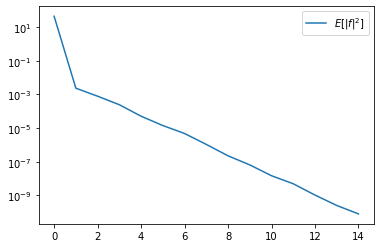

In [10]:
plt.plot(levels, res)
plt.yscale('log')
plt.legend([r'$E[|f|^2]$'])

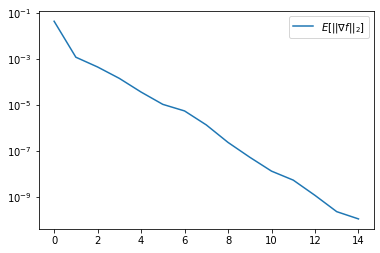

In [11]:
plt.plot(levels, res_grad)
plt.yscale('log')
plt.legend([r'$E[||\nabla f||_2]$'])

# Training Example

In [12]:
model.set_vec(V_true) 
x = generate(1000, V_true) 
model.loss(x).numpy(), tf.reduce_mean(model.loss_full(x)).numpy()

(6.773236430317455, 6.773206192343548)

In [13]:
model = mlmcWord2Vec(N,D)

optimizer = tf.keras.optimizers.Adam(0.005)

print('initial loss:', model.loss(x).numpy(), 'initial true loss:',tf.reduce_mean(model.loss_full(x)).numpy())

n_iter = 2000
for i in range(n_iter):
    x = generate(B*10, V_true)
    model.fit(x, optimizer, mlmc=False, n_MC=1000, w0=0.4, b=1.3)
    if (i+1)%(n_iter//10)==0:
        print('loss at #iter={}:'.format(i+1), model.loss(x).numpy(),
             '\ttrue loss:', tf.reduce_mean(model.loss_full(x)).numpy()) 

initial loss: 6.940674320559874 initial true loss: 6.940006028174096
loss at #iter=200: 6.903746646632522 	true loss: 6.904288051693499
loss at #iter=400: 6.897646415636839 	true loss: 6.897324877297968
loss at #iter=600: 6.869271127996635 	true loss: 6.869507003310201
loss at #iter=800: 6.8269051677613195 	true loss: 6.82833710960833
loss at #iter=1000: 6.827954027363199 	true loss: 6.829222972533227
loss at #iter=1200: 6.804101866179974 	true loss: 6.805760516572501
loss at #iter=1400: 6.802953181012712 	true loss: 6.8048414879031895
loss at #iter=1600: 6.787717849983248 	true loss: 6.790792344750903
loss at #iter=1800: 6.803667754542521 	true loss: 6.804064198146663
loss at #iter=2000: 6.819285459818434 	true loss: 6.81673451072614


In [14]:
x = generate(1000, V_true)
model.loss(x).numpy(), tf.reduce_mean(model.loss_full(x)).numpy()

(6.802087458580893, 6.805819376636567)

In [15]:
V = model.V.numpy()
np.linalg.norm(V@V.T - V_true@V_true.T), np.linalg.norm(V_true@V_true.T)

(94.65895783842285, 452.43221111340625)

# Evaluate runtime (variance per reciprocal runtime)

In [17]:
## TODO ##
# - divide the functionality to smaller functions
# - add simple nested MC
# - run in a 1-core environment

model = mlmcWord2Vec(N,D)

levels = [l for l in range(12)]
T = []
V = []
V_grad = []

for l in levels:
    times = []
    losses = []
    losses_grad = []
    for i in range(100):
        x = generate(10, V_true)
        s = time()
        with tf.GradientTape() as g:
            g.watch([model.V])
            loss = model.loss_mlmc(x, max_level=l, w0=0.4, b=1.3, randomize=True)
        grad = g.gradient(loss, model.V)
        del g
        grad = tf.convert_to_tensor(grad)
        t = time()
        times.append(t-s)
        losses.append(loss)
        losses_grad.append(grad)
    T.append(np.mean(times))
    V.append(np.var(losses))
    V_grad.append(np.mean(np.var(losses_grad, axis=0)))

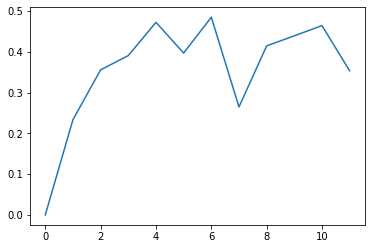

In [18]:
plt.plot(np.array(T)*np.array(V))

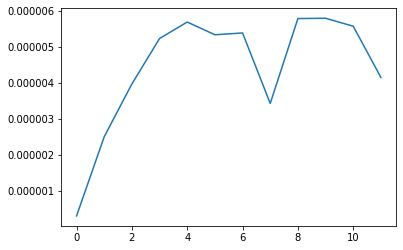

In [19]:
plt.plot(np.array(T)*np.array(V_grad))